The target of an observation is rarely the only object contributing light to a given exposure. Background contamination (which, for ground-based telescopes, is largely caused by Earth's atmosphere) can contribute its own wavelength-dependent features. Without careful correction, these erroneous features could show up in our reduced spectra, making it difficult to discern the chromatic properties of our target.

In this section, we apply ```specsuite```'s warp models to produce a high-quality estimate of this background contamination across the entire detector.

In [1]:
import specsuite as ss

DATA_REGION = (700, 800)
CAL_PATH = "../data/KOSMOS/calibrations"
DATA_PATH = "../data/KOSMOS/target"
INSTRUMENT = "kosmos"

# Loads calibration exposures
bias = ss.average_matching_files(
    path = CAL_PATH,
    tag = "bias",
    crop_bds = DATA_REGION,
    instrument = INSTRUMENT,
)
arclamp = ss.average_matching_files(
    path = CAL_PATH,
    tag = "neon",
    crop_bds = DATA_REGION,
    instrument = INSTRUMENT,
) - bias

# Loads science exposures
science = ss.collect_images_array(
    path = DATA_PATH,
    tag = "toi3884",
    crop_bds = DATA_REGION,
    instrument = INSTRUMENT,
) - bias

# Generates a decent warp model for our sample KOSMOS data
locs, _ = ss.find_cal_lines(arclamp, std_variation=200)
warp_model = ss.generate_warp_model(arclamp, locs)

## **Basic Usage**
### _Background Extraction_
Once a warp model has been generated, it is fairly trivial to perform a background extraction. The only additional piece of information we need is which rows should be masked to prevent the signal trace from throwing off our estimate of the background emission. For example, take a look at the following exposure...

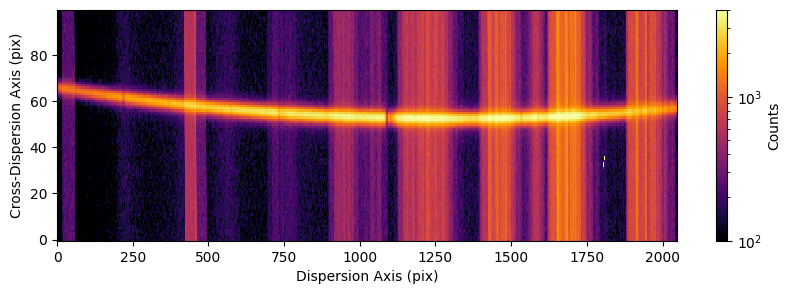

In [2]:
KWARGS = {"norm": "log", "vmin": 1e2, "vmax": 4e3}

ss.plot_image(science[0], **KWARGS)

We can see that the trace spans the cross-dispersion axis from ~40-80 pixels. These rows should be masked out during our background extraction. Once your warp model has been generated, a series of background exposures can be extracted by calling...

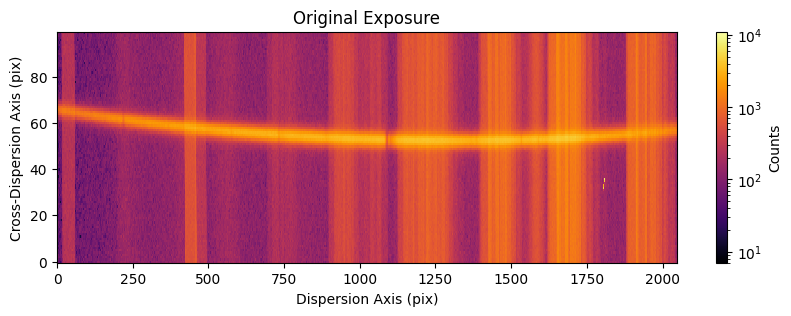

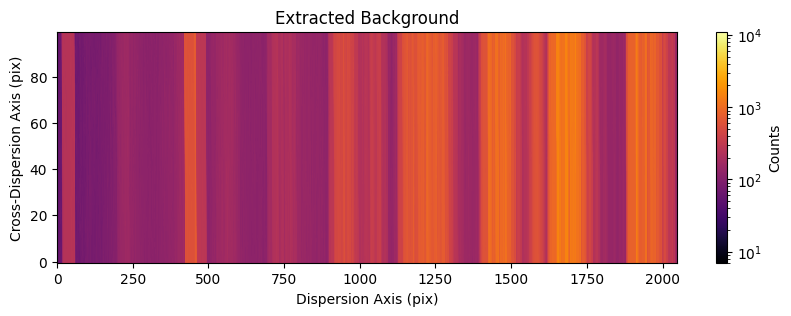

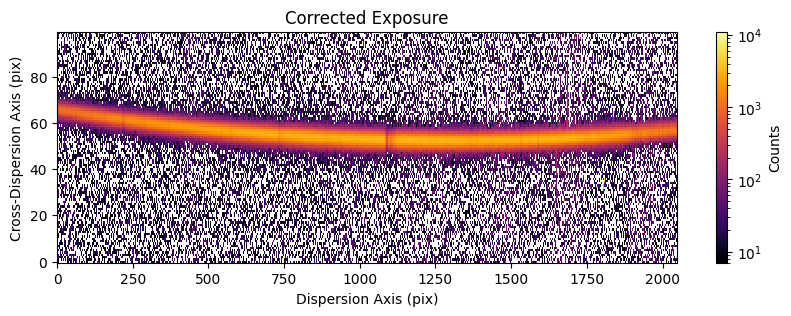

In [3]:
MASK_REGION = (40, 80)

background = ss.extract_background(
    images = science,
    warp_model = warp_model,
    mask_region = MASK_REGION,
    debug = True,
)

Note that the colorbars of all three plots are on a log scale (values less than 0 show up as white). The fact that the non-illuminated regions of our image look like random static is a sign that our extraction and correction were accurate! If you wanted to verify these results using some additional metrics, ```extract_background()``` has some optional returns that may be useful.

### _Effective Pixel Map_
To understand how the above function works, it can be helpful to look at some option returns for ```extract_background()``` using the ```return_spectrum = True```...

In [4]:
# Re-runs background extraction and collects additional returns
returned_data = ss.extract_background(
    images = science,
    warp_model = warp_model,
    mask_region = MASK_REGION,
    return_spectrum = True,
)

# Unpacks returned data into separate arrays
_, background_effpix, background_flux, effpix_map = returned_data

The first of these new returns we will discuss is called the "__effective pixel map__". Assuming that light is warped as it falls onto camera, a given wavelength may not fall onto the same dispersion axis location. Using the __warp models__ generated in the last step, we can approximate how a wavelength's dispersion-axis location changes along the cross-dispersion axis. So, if two pixels in the "__effective pixel map__" have the same value, that means that the same wavelength falls onto those pixels. Let's take a look at an example to illustrate this concept...

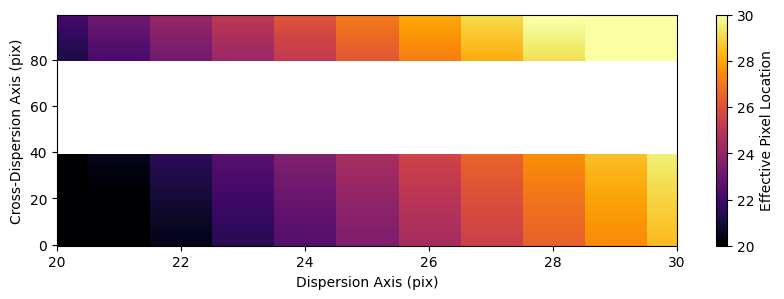

In [5]:
# Plots a small region of the effective pixel map
ss.plot_image(
    effpix_map,
    cbar_label = "Effective Pixel Location",
    xlim = (20, 30),
    vmin = 20,
    vmax = 30,
)

In this zoomed-in view, we can see a slightly curved gradient. Let (x, y) represent the dispersion and cross-dispersion locations in the above image. Since, the color at (26, 0) is identical to the color at (23, 100), the same wavelength falls at both of those locations.

The effective pixel map is calculated directly from the provieed warp models. If you are seeing weird features in your extracted background, that is a good sign that something went wrong in your warp model generation.

<div class="admonition note">
    <p class="admonition-title">Note</p>
    <p>
        The white bars present in the effective pixel map represent the region we masked out during the background extraction (see the MASK_REGION variable). Each of these pixels has a NaN value to help us filter them out during the extraction process.
    </p>
</div>

### _Extracted Background SED_
Once the effective pixel map has been generated, ```extract_background()``` attempts to estimate how strong the background emissions are as a function of effective pixel location. It does this by scanning over each unmasked row, extracting the brightness at each pixel in the row, and adding each pixel to a spectra with (effective pixel location, counts) being the point's coordinates. Two of the optional returns allow us to visualize this super-sampled background emission spectra...

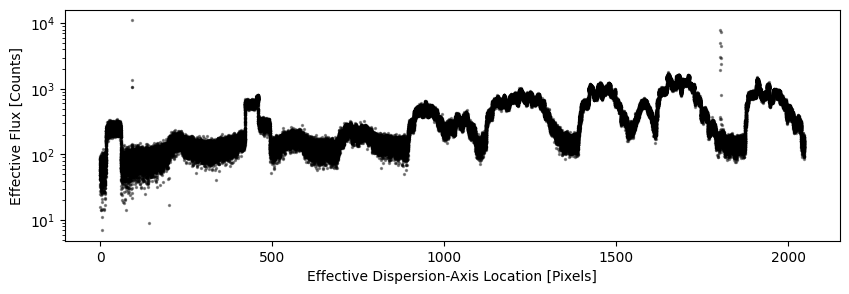

In [6]:
import matplotlib.pyplot as plt

# Plots the supersampled background spectra
plt.scatter(
    returned_data[1],
    returned_data[2][0],
    color = "black",
    alpha = 0.4,
    s = 2,
)

# Formats the labels and scaling
plt.xlabel("Effective Dispersion-Axis Location [Pixels]")
plt.ylabel("Effective Flux [Counts]")
plt.yscale("log")
plt.show()

This SED is calculated for each individual exposure. The final, slightly complicated step in the background extraction involves taking the median of a subset of the above SED for every pixel in an image. Let (L, R) be the effective pixel locations of a given pixel's left and right edges. Then...

\begin{equation*}
    \textbf{S}(x, y) = \text{med}\left[ f(L < x < R) \right]
\end{equation*}

...represents the extracted background contribution. By using a median over a super-sampled SED, we mitigate the impact of cosmic rays, statistical noise, and other weird features during our extraction.

<div class="admonition warning">
    <p class="admonition-title">Warning</p>
    <p>
        This process is fairly computationally-expensive. For the example KOSMOS data used above, this operation needs to be performed for every pixel of every exposure (~200,000 calculations per image)! We have vectorized many of these operations to make them as efficient as possible, but it still may take several minutes to process your exposures. The extraction also attempts to split up the computations over several cores, but this is only useful for computers with several cores capable of parallel processing.
    </p>
</div>

## __Common Errors__
### _Bad Masking_
While providing a MASK_REGION is not necessary for ```extract_background()``` to run, we highly recommend doing so. Let's take a look at an example where we did not mask out the signal trace...

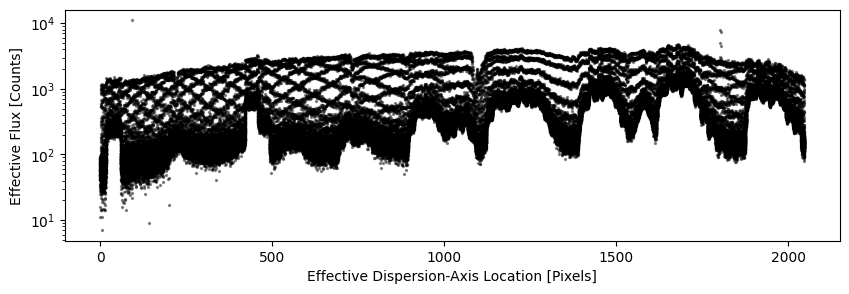

In [7]:
import matplotlib.pyplot as plt

# Re-runs background extraction and collects additional returns
returned_data = ss.extract_background(
    images = science,
    warp_model = warp_model,
    return_spectrum = True,
)

# Plots the supersampled background spectra
plt.scatter(
    returned_data[1],
    returned_data[2][0],
    color = "black",
    alpha = 0.4,
    s = 2,
)

# Formats the labels and scaling
plt.xlabel("Effective Dispersion-Axis Location [Pixels]")
plt.ylabel("Effective Flux [Counts]")
plt.yscale("log")
plt.show()

We can see that the trace shows up as odd features in our super-sampled background spectra. These features can interfere with the accuracy of your extracted background. If you are unsure whether you have masked out the right region of your image, check to see if your supersampled background spectra contains these features.

### *Bad Warp Models*

If the ```warp_model``` produced by ```generate_warp_model()``` is poor, the extracted background will often look weird. There are plenty of situations that could lead to poor model generation, but it usually comes down to a bad choice of ```guess``` or ```tolerance```. For example, if we only look at a small region of data and shrink our tolerance, we get the following results...

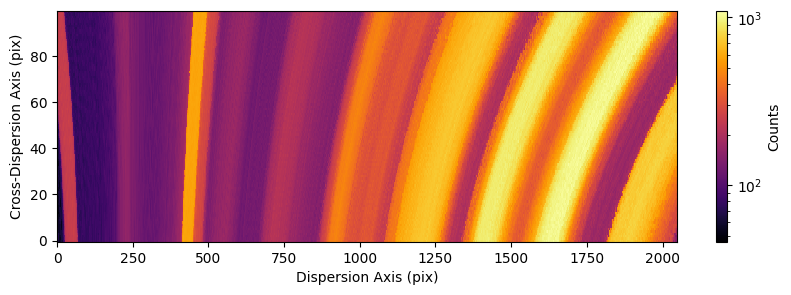

In [8]:
# THe 'guess' is set to small, dim portions of exposure
bad_warp_model = ss.generate_warp_model(
    image = arclamp,
    guess = [250, 260, 270],
    tolerance = 2,
)

background = ss.extract_background(
    images = science,
    warp_model = bad_warp_model,
    mask_region = (50, 90),
)

ss.plot_image(background[0], norm = 'log')

If you encounter this error, please revist the code used to generate your warp model. You may need to adjust some of the optional parameters for your data.

### *Non-Uniform Background*

This algorithm assumes that all background emissions are approximately uniform along to the cross-dispersion direction. If your background is spectrally non-uniform, then the resulting background-subtraction can produce large residuals...

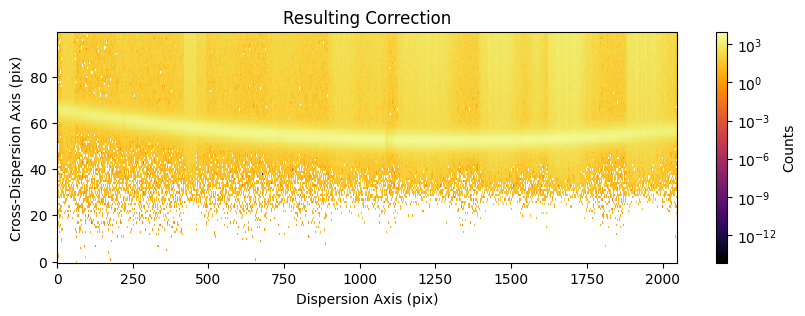

In [9]:
import numpy as np

# Generates a fake flatfield with a strong gradient
gradient = np.linspace(0.5, 1.5, arclamp.shape[0])[:, None]
bad_flatfield = gradient * np.ones(arclamp.shape[1])
bad_science = science*bad_flatfield

# Performs a background extraction
background = ss.extract_background(
    images = bad_science,
    warp_model = warp_model,
    mask_region = (50, 90),
)

# Plots the first 'bad' background correction
ss.plot_image(
    (bad_science-background)[0],
    title = "Resulting Correction",
    norm = 'log',
)

Ideally, all pixels that are not illuminated by the signal trace should look like random static. If you see clear structure over these non-illuminated pixels, you should double-check that you have performed a flatfield calibration on your exposures.